In [1]:
from nilearn.image import resample_to_img, load_img
from nilearn.datasets import (
    load_mni152_template,
)

template_img = load_mni152_template(resolution=4)

img = load_img('derivatives/sub-70001/func/sub-70001_task-rest_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')

resampled_img = resample_to_img(img, template_img, force_resample=True, copy_header=True)

In [4]:
from nilearn.datasets import fetch_atlas_msdl
msdl_data = fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
print(
    f"MSDL has {n_regions} ROIs, "
    f"part of the following networks:\n{msdl_data.networks}."
)

[fetch_atlas_msdl] Dataset found in /home/rongfei/nilearn_data/msdl_atlas

MSDL has 39 ROIs, part of the following networks:
['Aud', 'Aud', 'Striate', 'DMN', 'DMN', 'DMN', 'DMN', 'Occ post', 'Motor', 'R V Att', 'R V Att', 'R V Att', 'R V Att', 'Basal', 'L V Att', 'L V Att', 'L V Att', 'D Att', 'D Att', 'Vis Sec', 'Vis Sec', 'Vis Sec', 'Salience', 'Salience', 'Salience', 'Temporal', 'Temporal', 'Language', 'Language', 'Language', 'Language', 'Language', 'Cereb', 'Dors PCC', 'Cing-Ins', 'Cing-Ins', 'Cing-Ins', 'Ant IPS', 'Ant IPS'].


In [155]:
from nilearn.datasets import fetch_atlas_difumo

difumo_data = fetch_atlas_difumo()
print(difumo_data.labels)


[fetch_atlas_difumo] Dataset found in /home/rongfei/nilearn_data/difumo_atlases

    component                       difumo_names     yeo_networks7  \
0           1            Superior frontal sulcus          DefaultB   
1           2                     Fusiform gyrus  No network found   
2           3         Calcarine cortex posterior           VisCent   
3           4         Cingulate cortex posterior          DefaultB   
4           5  Parieto-occipital sulcus superior             ContA   
..        ...                                ...               ...   
59         60                             Cuneus           VisCent   
60         61              Middle temporal gyrus          DefaultB   
61         62             Superior frontal gyrus          DefaultB   
62         63                     Central sulcus           SomMotA   
63         64                            Caudate  No network found   

      yeo_networks17        gm        wm       csf  
0           DefaultA  0.689996  0.185709  0.116884  
1   No network found  0.844733  0.021026  0.133789  


In [ ]:
from re import A
import pandas as pd
# load subject list
adhd_subject_list = pd.read_csv("adhd_subjects_ids.txt", header=None)
control_subject_list = pd.read_csv("control_subjects_ids.txt", header=None)

adhd_subject_list["phenotype"] = "ADHD"
control_subject_list["phenotype"] = "Control"

subject_list = pd.concat([adhd_subject_list, control_subject_list])
subject_list.columns = ["subject_id", "phenotype"]

   subject_id phenotype
0   sub-70001      ADHD
1   sub-70004      ADHD
2   sub-70010      ADHD
3   sub-70015      ADHD
4   sub-70017      ADHD
..        ...       ...
30  sub-11088   Control
31  sub-10455   Control
32  sub-11062   Control
33  sub-10871   Control
34  sub-10339   Control

[70 rows x 2 columns]


In [13]:
from nilearn.maskers import NiftiMapsMasker
masker = NiftiMapsMasker(
    msdl_data.maps,
    resampling_target="data",
    t_r=2,
    detrend=True,
    low_pass=0.1,
    high_pass=0.01,
    memory="nilearn_cache",
    memory_level=1,
    standardize="zscore_sample",
    standardize_confounds=True,
)


In [156]:
masker_difumo = NiftiMapsMasker(
    difumo_data.maps,
    resampling_target="data",
    t_r=2,
    detrend=True,
    low_pass=0.1,
    high_pass=0.01,
    memory="nilearn_cache",
    memory_level=1,
    standardize_confounds=True,
)


In [36]:
from analysis.subject import SubjectInfo
from tqdm import tqdm

subject_mask_fits = []
for i, row in tqdm(subject_list.iterrows(), total=len(subject_list)):
    subject_id = row["subject_id"]
    subject_info = SubjectInfo(subject_id)
    rest_image = subject_info.get_rest_image()
    confounds_file = subject_info.get_rest_confounds_file()
    if not rest_image.exists() or not confounds_file.exists():
        print(f"Subject {subject_id} has no rest image or confounds file")
        continue
    confounds = pd.read_csv(confounds_file, sep="\t")
    # interpolate confounds
    confounds.bfill(inplace=True)
    # print dtype of first row
    time_series = masker.fit_transform(rest_image, confounds=confounds)
    subject_mask_fits.append(time_series)

100%|██████████| 70/70 [03:01<00:00,  2.60s/it]


In [157]:
def fit_masker(masker, subject_list):
    subject_mask_fits = []
    for i, row in tqdm(subject_list.iterrows(), total=len(subject_list)):
        subject_id = row["subject_id"]
        subject_info = SubjectInfo(subject_id)
        rest_image = subject_info.get_rest_image()
        confounds_file = subject_info.get_rest_confounds_file()
        if not rest_image.exists() or not confounds_file.exists():
            print(f"Subject {subject_id} has no rest image or confounds file")
            continue
        confounds = pd.read_csv(confounds_file, sep="\t")
        # interpolate confounds
        confounds.bfill(inplace=True)
        time_series = masker.fit_transform(rest_image, confounds=confounds)
        subject_mask_fits.append(time_series)
    return subject_mask_fits

subject_mask_fits_difumo = fit_masker(masker_difumo, subject_list)



100%|██████████| 70/70 [05:05<00:00,  4.37s/it]


In [ ]:
import numpy as np
# Separate using list comprehension
def separate_by_phenotype(subject_mask_fits, subject_list):
    adhd_fits = [obj for obj, type_val in zip(subject_mask_fits, subject_list['phenotype']) if type_val == 'ADHD']
    control_fits = [obj for obj, type_val in zip(subject_mask_fits, subject_list['phenotype']) if type_val == 'Control']
    return adhd_fits, control_fits




In [60]:
from nilearn.connectome import ConnectivityMeasure

def get_connectivity_matrix(subject_mask_fits, kind="correlation", standardize=True, mean=False):
    connectivity_measure = ConnectivityMeasure(
        kind=kind,
        standardize=standardize,
    )
    connectivity_matrices = connectivity_measure.fit_transform(subject_mask_fits)
    if mean:
        return connectivity_measure.mean_
    return connectivity_matrices


adhd_mean_connectivity_matrix = get_connectivity_matrix(adhd_fits)
control_mean_connectivity_matrix = get_connectivity_matrix(control_fits)





In [134]:
adhd_mean_connectivity_matrix.shape

(35, 39, 39)

/tmp/ipykernel_1977653/3576725279.py:16: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  plot_pair(i)


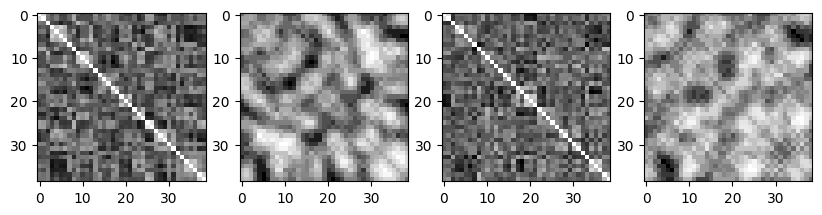

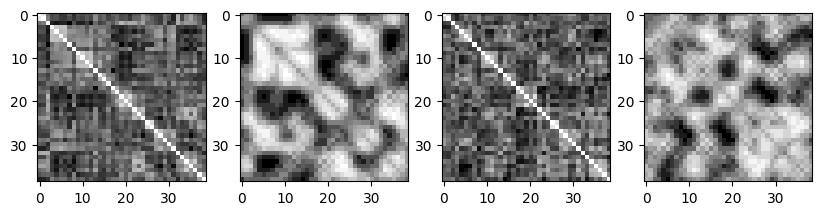

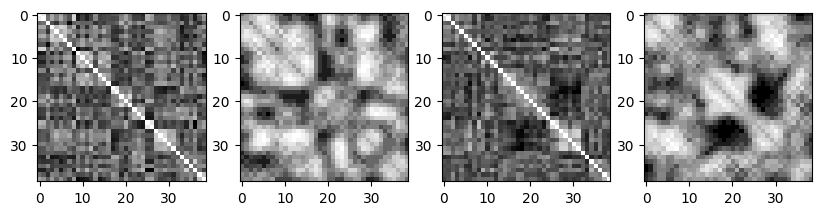

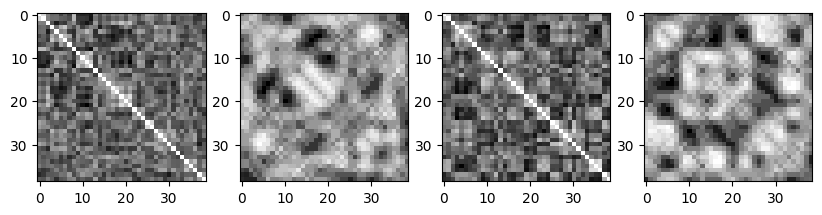

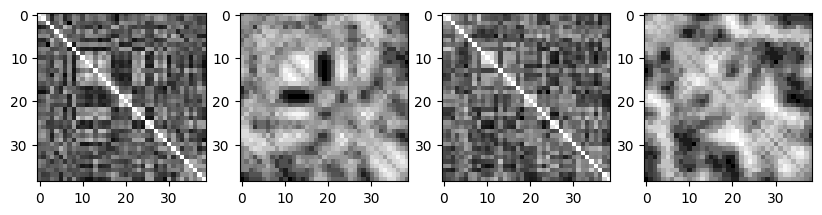

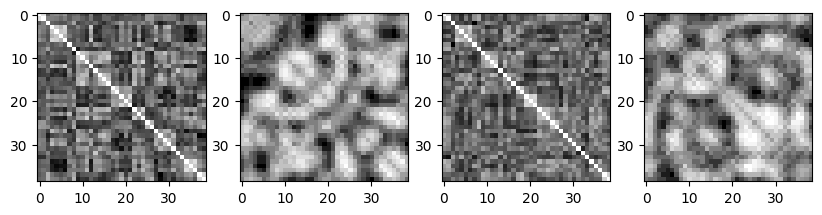

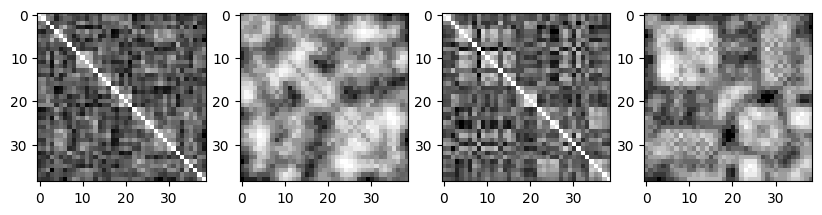

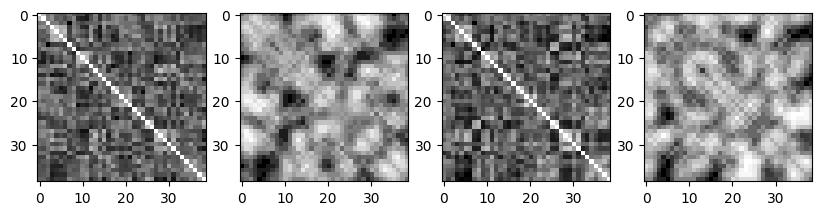

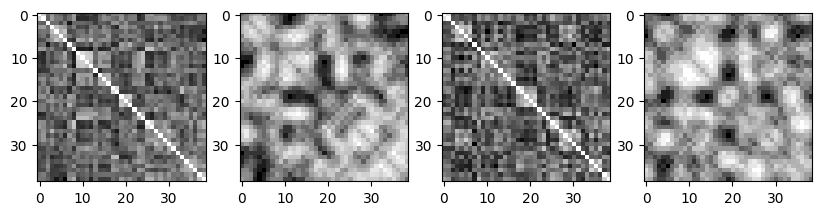

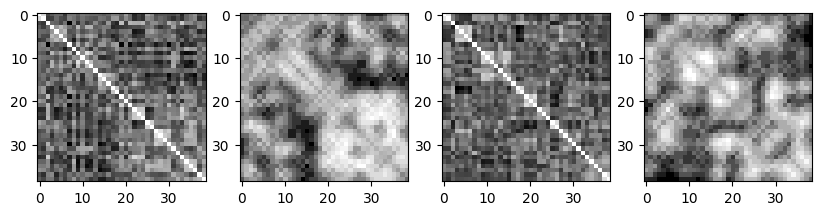

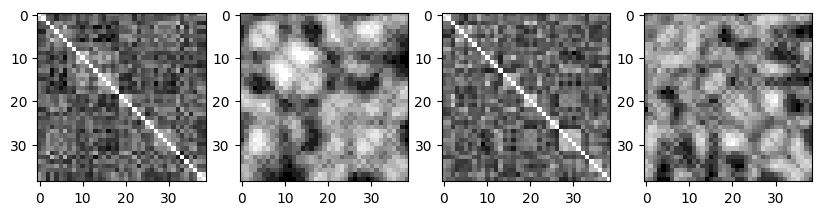

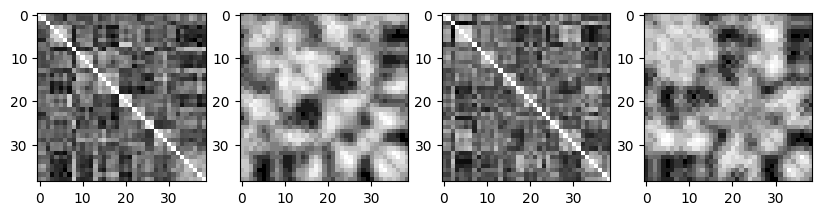

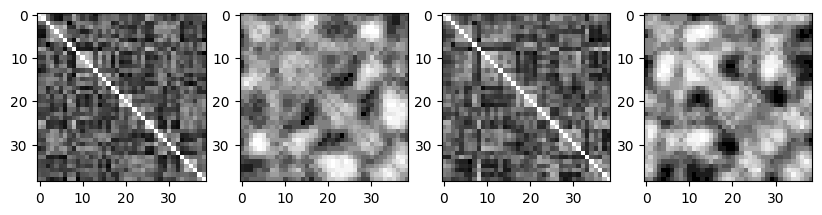

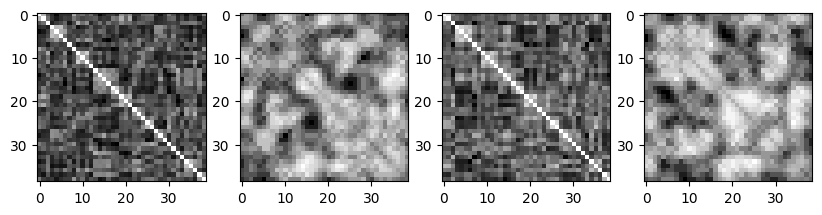

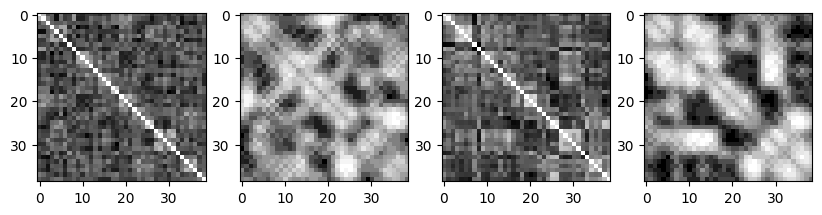

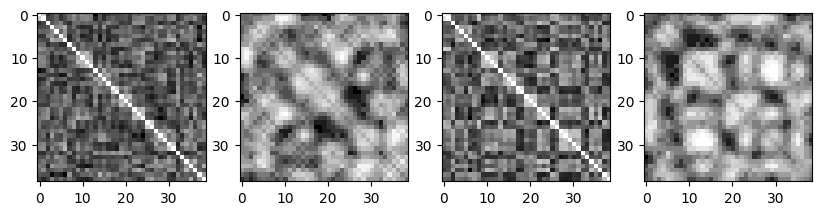

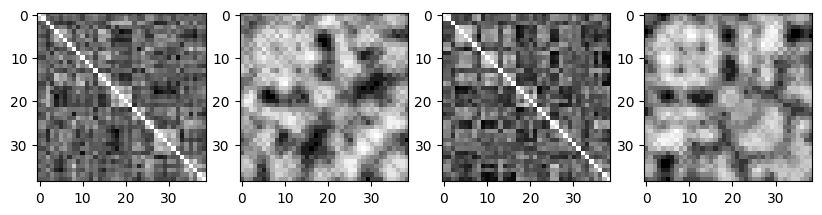

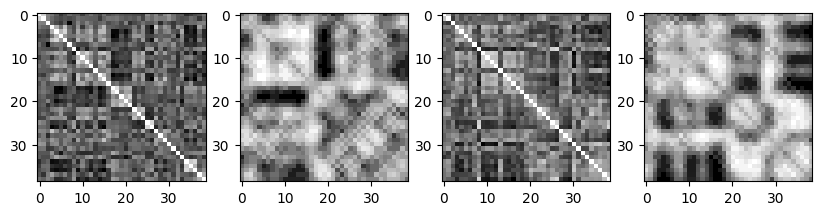

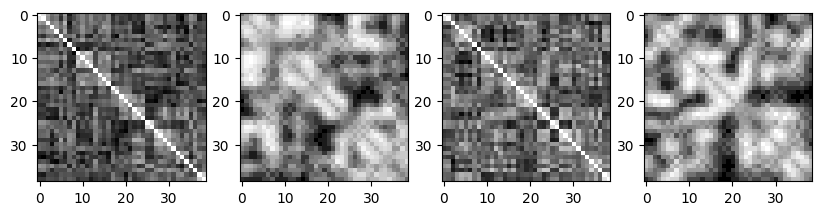

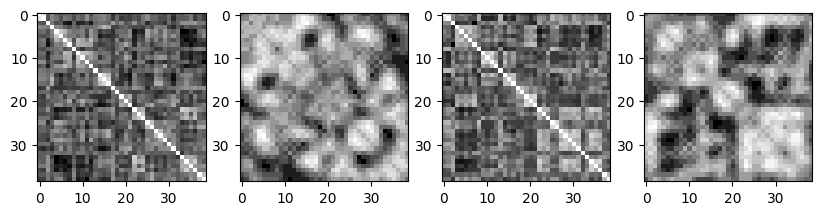

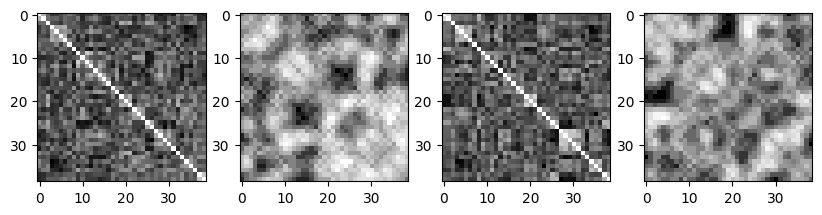

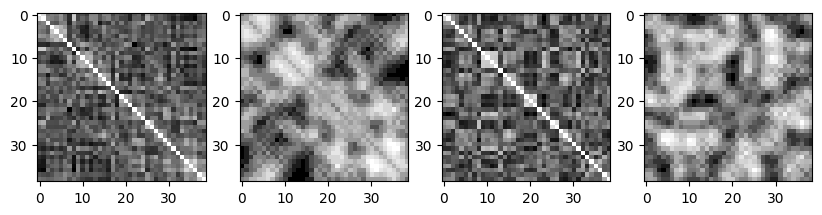

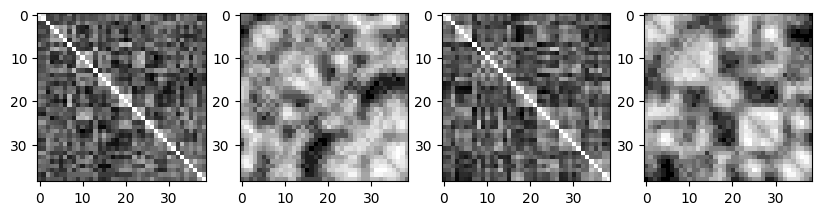

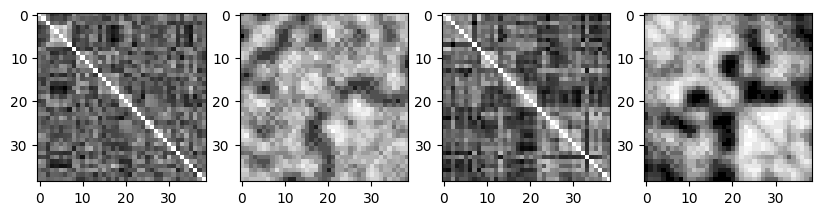

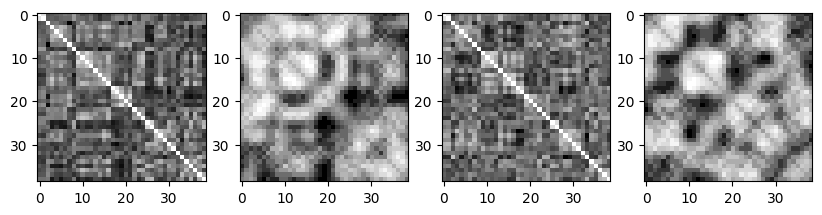

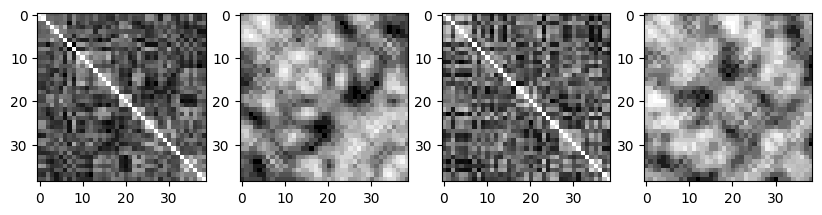

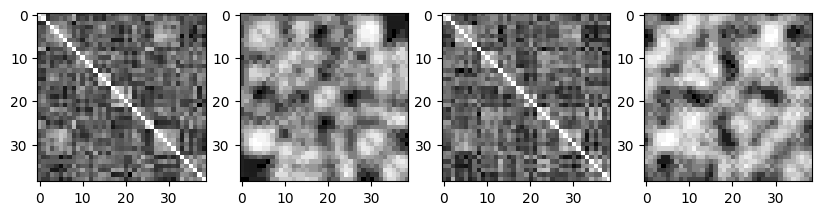

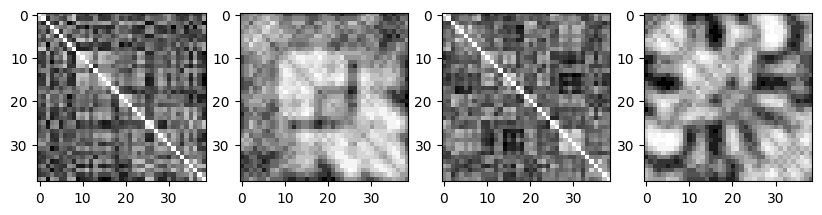

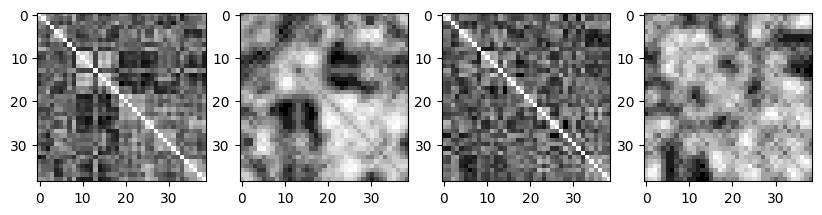

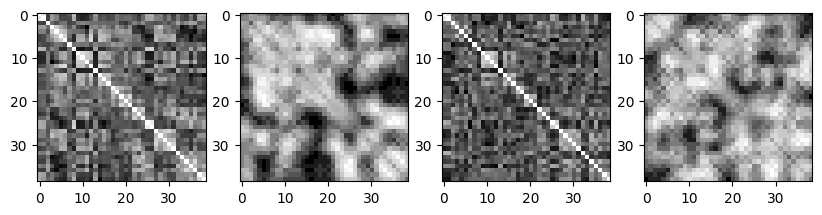

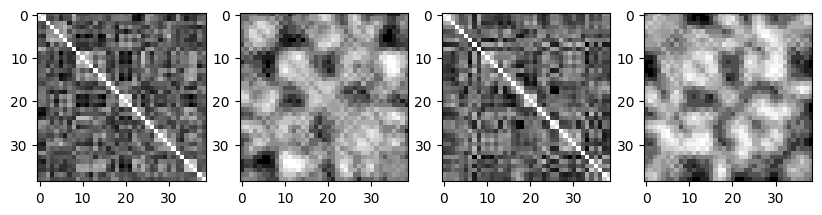

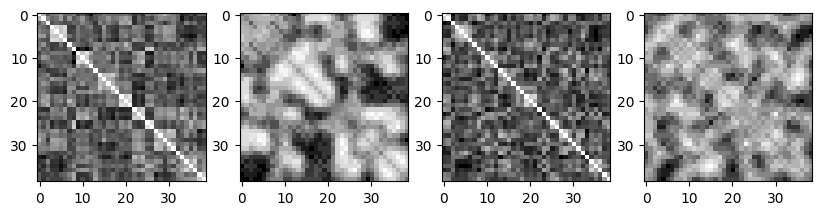

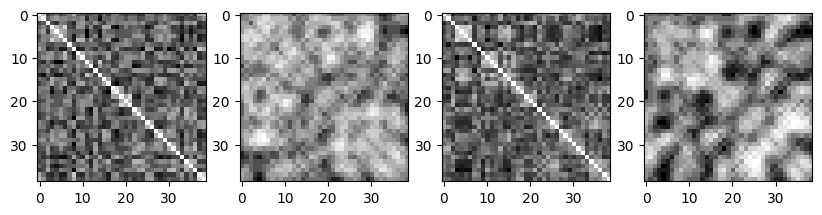

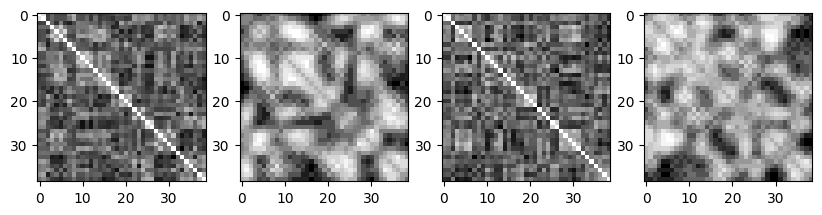

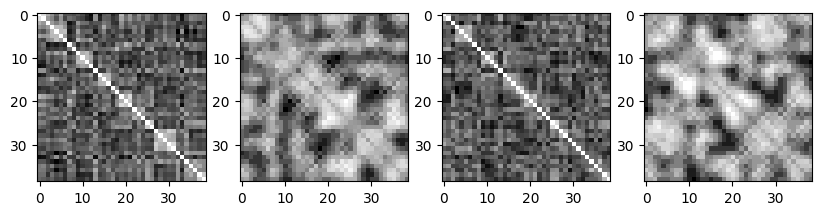

In [151]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
import matplotlib.pyplot as plt

def plot_pair(i, disk_size=2):
    fig, ax = plt.subplots(1, 4, figsize=(10, 5))
    adhd_entropy_image = entropy(adhd_mean_connectivity_matrix[i], disk(disk_size))
    control_entropy_image = entropy(control_mean_connectivity_matrix[i], disk(disk_size))
    ax[0].imshow(adhd_mean_connectivity_matrix[i], cmap="gray")
    ax[1].imshow(adhd_entropy_image, cmap="gray")
    ax[2].imshow(control_mean_connectivity_matrix[i], cmap="gray")
    ax[3].imshow(control_entropy_image, cmap="gray")
    plt.show()

for i in range(35):
    plot_pair(i)



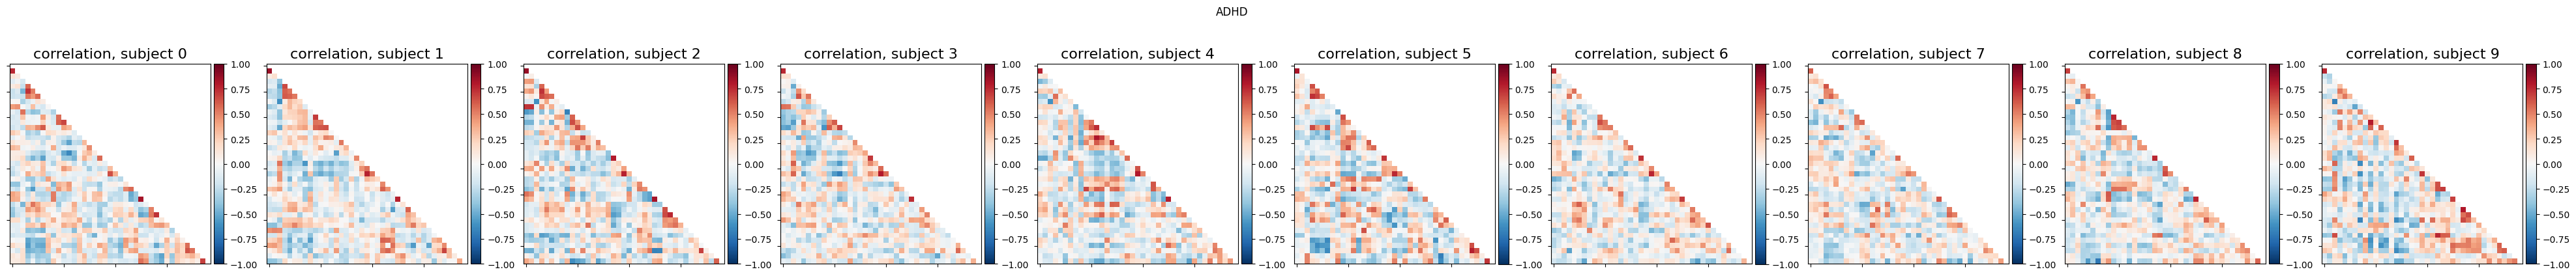

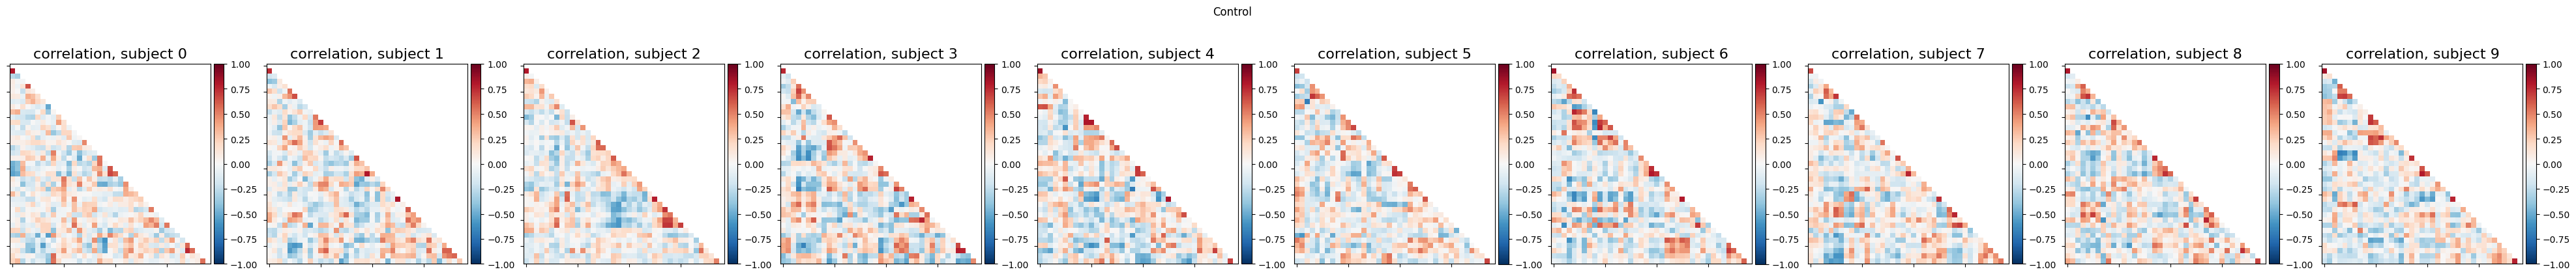

In [130]:
import numpy as np
from matplotlib import pyplot as plt
from nilearn.plotting import plot_connectome, plot_matrix, show

def plot_connectome_with_samples(connectivity_matrices, title):
    n = 10
    width = 5*n
    fig, axes = plt.subplots(1, n, figsize=(width, 5))
    fig.suptitle(title)
    vmax = np.absolute(connectivity_matrices).max()
    for i, (matrix, ax) in enumerate(zip(connectivity_matrices, axes)):
        plot_matrix(
            matrix,
            tri="lower",
            axes=ax,
            title=f"correlation, subject {i}",
            vmax=vmax,
            vmin=-vmax,
        )
plot_connectome_with_samples(adhd_mean_connectivity_matrix, "ADHD")
plot_connectome_with_samples(control_mean_connectivity_matrix, "Control")

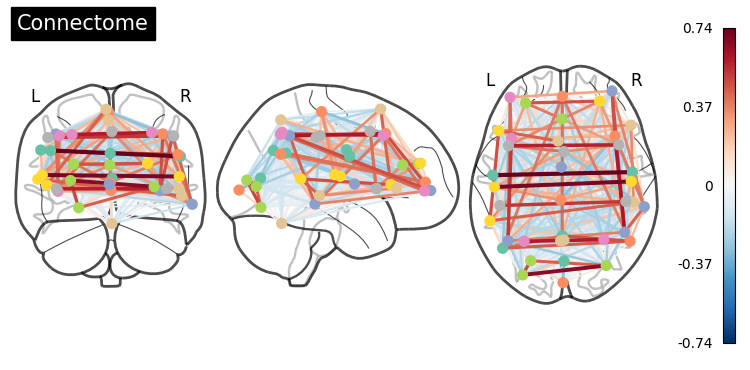

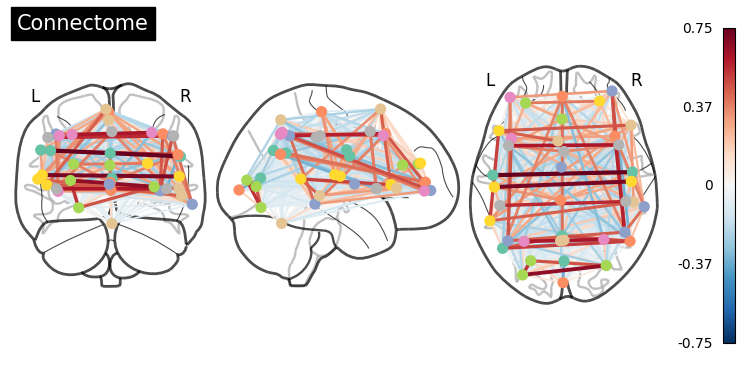

In [57]:
adhd_mean_connectivity_matrix = get_connectivity_matrix(adhd_fits, mean=True)
plot_connectome(adhd_mean_connectivity_matrix, msdl_coords, title="Connectome")

control_mean_connectivity_matrix = get_connectivity_matrix(control_fits, mean=True)
plot_connectome(control_mean_connectivity_matrix, msdl_coords, title="Connectome")






In [160]:
def remove_problem_subjects(subject_mask_fits): 
    filter_subject_mask_fits = []
    problem_idx = []
    for i, fit in enumerate(subject_mask_fits):
        if fit.shape[0] == 152:
            filter_subject_mask_fits.append(fit)
        else:
            problem_idx.append(i)

    filter_subject_mask_fits = np.array(filter_subject_mask_fits)
    filter_subject_list = subject_list.reset_index().drop(problem_idx)
    return filter_subject_mask_fits, filter_subject_list

In [161]:
filter_subject_mask_fits_difumo, filter_subject_list_difumo = remove_problem_subjects(subject_mask_fits_difumo)

51 18
51 18
51 18
51 18
51 18
51 18
51 18
51 18
51 18
51 18
51 18
51 18
51 18
51 18
51 18


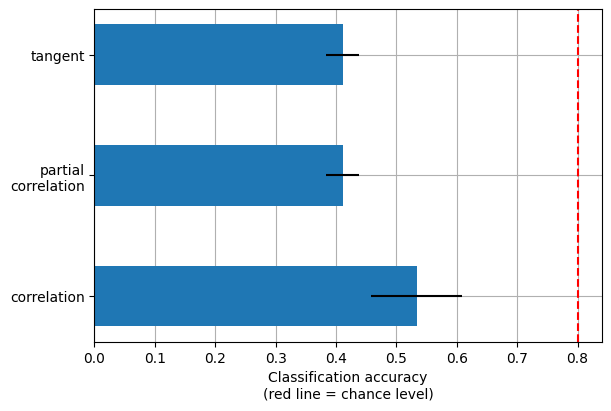

In [177]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC

def cv_train_test(subject_mask_fits, subject_list, kinds = ["correlation", "partial correlation", "tangent"]):

    cv = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.25)

    X = np.arange(len(subject_list))
    y = subject_list['phenotype'].to_numpy()




    scores = {}
    for kind in kinds:
        scores[kind] = []
        for train_idx, test_idx in cv.split(X, y):
            print(len(train_idx), len(test_idx))
            connectivity = ConnectivityMeasure(
                kind=kind,
                vectorize=True,
            )
            # build vectorized connectomes for subjects in the train set
            connectomes = connectivity.fit_transform(subject_mask_fits[train_idx])
            # fit the classifier
            classifier = LinearSVC().fit(connectomes, y[train_idx])
            # make predictions for the left-out test subjects
            predictions = classifier.predict(
                connectivity.transform(subject_mask_fits[test_idx])
            )
            # store the accuracy for this cross-validation fold
            scores[kind].append(accuracy_score(y[test_idx], predictions))
    return scores

def plot_scores(scores, kinds):
    mean_scores = [np.mean(scores[kind]) for kind in kinds]
    scores_std = [np.std(scores[kind]) for kind in kinds]

    plt.figure(figsize=(6, 4), constrained_layout=True)

    positions = np.arange(len(kinds)) * 0.1 + 0.1
    plt.barh(positions, mean_scores, align="center", height=0.05, xerr=scores_std)
    yticks = [k.replace(" ", "\n") for k in kinds]
    plt.yticks(positions, yticks)
    plt.gca().grid(True)
    plt.gca().set_axisbelow(True)
    plt.gca().axvline(0.8, color="red", linestyle="--")
    plt.xlabel("Classification accuracy\n(red line = chance level)")

kinds = ["correlation", "partial correlation", "tangent"]
scores = cv_train_test(filter_subject_mask_fits_difumo, filter_subject_list_difumo, kinds)
plot_scores(scores, kinds)


In [192]:
subject_mask_fits_difumo[0].shape

(152, 64)

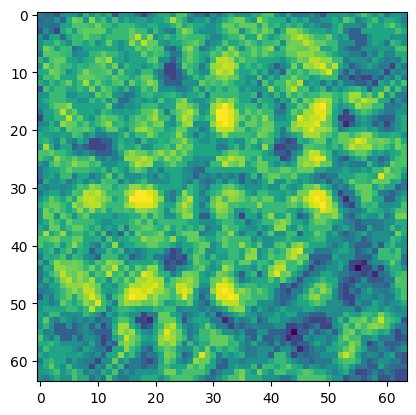

In [214]:
from torch.utils.data import DataLoader, Dataset, Subset
from skimage.util import img_as_ubyte
import torch

def apply_entropy(image, disk_size=2):
    image = img_as_ubyte(image.squeeze())
    return np.expand_dims(entropy(image, disk(disk_size)), axis=0)

class ConnectomeDataset(Dataset):
    def __init__(self, subject_mask_fits, subject_list):
        self.subject_mask_fits = subject_mask_fits
        self.subject_list = subject_list
        connectivity = ConnectivityMeasure(
            kind="correlation",
        )
        self.connectomes = []
        # build vectorized connectomes for subjects in the train set
        for subject_mask_fit in subject_mask_fits:
            matrix = connectivity.fit_transform(subject_mask_fit)
            self.connectomes.append(matrix)

    def __len__(self):
        return len(self.subject_list)

    def __getitem__(self, idx):
        img = apply_entropy(self.connectomes[idx])
        return torch.from_numpy(img).float(), self.subject_list['phenotype'].map({"ADHD": 1, "Control": 0}).iloc[idx]
    
    def cv_split(self, n_splits=5, test_size=0.25):
        cv = StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.25)
        for train_idx, test_idx in cv.split(self.subject_list, self.subject_list['phenotype']):
            yield train_idx, test_idx
    

dataset = ConnectomeDataset(filter_subject_mask_fits_difumo, filter_subject_list_difumo)

fig, ax = plt.subplots(1, 1)
ax.imshow(dataset[0][0].squeeze())





In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class GrayscaleCNN(nn.Module):
    """
    2D Grayscale Image CNN with overfitting reduction techniques:
    - Dropout layers
    - Batch Normalization
    - L2 Regularization (applied via optimizer)
    - Progressive channel reduction
    """
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(GrayscaleCNN, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(p=0.25)
        
        # Convolutional Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(p=0.25)
        
        # Convolutional Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(p=0.25)
        
        # Global Average Pooling (reduces parameters compared to flatten)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(p=dropout_rate)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn8 = nn.BatchNorm1d(128)
        self.dropout5 = nn.Dropout(p=dropout_rate)
        
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Fully Connected
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        
        x = F.relu(self.bn8(self.fc2(x)))
        x = self.dropout5(x)
        
        x = self.fc3(x)
        
        return x


# Training function with Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta:float=0.0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.mode == 'min':
            if val_loss < self.best_loss - self.min_delta:
                self.best_loss = val_loss
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
        return self.early_stop



    # Initialize model
model = GrayscaleCNN(num_classes=2, dropout_rate=0.5)


dummy_input = torch.randn(4, 1, 64, 64)  # Batch of 4 grayscale 64x64 images
output = model(dummy_input)
print(f"\nInput shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")



Input shape: torch.Size([4, 1, 64, 64])
Output shape: torch.Size([4, 2])


In [229]:
def train_model(model, train_loader, val_loader, num_epochs=50, 
                learning_rate=0.001, weight_decay=1e-4, device='cuda'):
    """
    Train the model with L2 regularization and early stopping
    """
    model = model.to(device)
    
    # Loss and optimizer with L2 regularization (weight_decay)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                                 weight_decay=weight_decay)
    
    # Learning rate scheduler (reduces LR when validation loss plateaus)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.8, patience=5, 
    )
    
    
    train_losses = []
    val_losses = []
    
    best_model = None
    best_accuracy = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = 100 * correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {val_accuracy:.2f}%')
        
        # Update learning rate
        scheduler.step(val_loss)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
        

    results = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "best_model": best_model,
        "best_accuracy": best_accuracy,
    }
    
    return results



In [230]:
dataset = ConnectomeDataset(filter_subject_mask_fits_difumo, filter_subject_list_difumo)

best_scores = []
best_models = []

for train_idx, test_idx in dataset.cv_split(n_splits=5, test_size=0.5):
    train_dataset = Subset(dataset, list(train_idx))
    test_dataset = Subset(dataset, list(test_idx))

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

    for images, labels in train_loader:
        print(images.shape)
        print(labels)
        break

    model = GrayscaleCNN(num_classes=2, dropout_rate=0.5)
    results = train_model(model, train_loader, test_loader)
    best_scores.append(results["best_accuracy"])

print(sum(best_scores) / len(best_scores))


torch.Size([4, 1, 64, 64])
tensor([0, 1, 0, 1])
Epoch [1/50], Train Loss: 0.7160, Val Loss: 0.7013, Val Accuracy: 50.00%
Epoch [2/50], Train Loss: 0.7319, Val Loss: 0.7038, Val Accuracy: 50.00%
Epoch [3/50], Train Loss: 0.7330, Val Loss: 0.7875, Val Accuracy: 50.00%
Epoch [4/50], Train Loss: 0.7368, Val Loss: 0.7198, Val Accuracy: 33.33%
Epoch [5/50], Train Loss: 0.8796, Val Loss: 0.7126, Val Accuracy: 33.33%
Epoch [6/50], Train Loss: 0.7684, Val Loss: 0.7230, Val Accuracy: 50.00%
Epoch [7/50], Train Loss: 0.8257, Val Loss: 0.7148, Val Accuracy: 50.00%
Epoch [8/50], Train Loss: 0.7481, Val Loss: 0.7088, Val Accuracy: 44.44%
Epoch [9/50], Train Loss: 0.7348, Val Loss: 0.6917, Val Accuracy: 61.11%
Epoch [10/50], Train Loss: 0.7515, Val Loss: 0.6845, Val Accuracy: 55.56%
Epoch [11/50], Train Loss: 0.7128, Val Loss: 0.6956, Val Accuracy: 38.89%
Epoch [12/50], Train Loss: 0.7087, Val Loss: 0.6939, Val Accuracy: 50.00%
Epoch [13/50], Train Loss: 0.7366, Val Loss: 0.6966, Val Accuracy: 44.44%

57.777777777777786
